利用你的資料, 用LG 及 SVM兩種演算法, 將全部特徵放入訓練, 建立模型, 並利用下面的指標評估模型, (1) 混淆矩陣(2) Precision, Accuracy, Recall, F1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering import
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder ,OrdinalEncoder
from imblearn.over_sampling import SMOTE

# Model import
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Evaluate import
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score ,roc_curve ,classification_report, confusion_matrix

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option("display.precision", 2)
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

# EDA
讀取資料，做資料探索

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/大三/下學期/機器學習應用/Datasets/california_housing_train/california_housing_train_original.csv')
df # 20640 rows × 10 columns

In [ ]:
df.info()

In [ ]:
import missingno as msno

msno.bar(df)

total_bedrooms有207筆的空值

In [ ]:
# Numerical statistics
df.describe()

In [ ]:
# Object statistics
df.describe(include=['object'])

In [ ]:
numerical_columns = df.select_dtypes(include='number').columns

plt.figure(figsize=(14, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[column], bins=20, kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

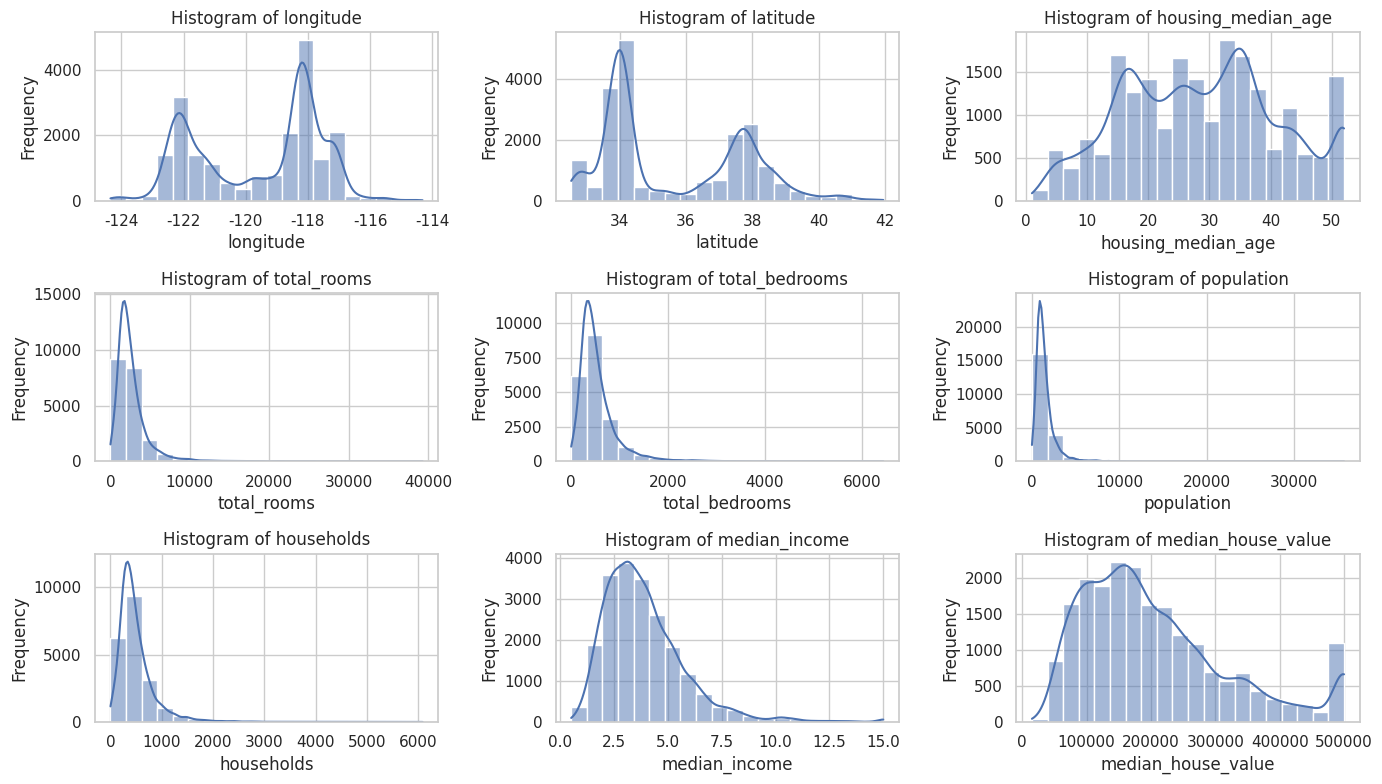

# Processing Data

In [ ]:
df.rename(columns={'housing_median_age' :'housing_age'}, inplace=True)
df.rename(columns={'median_income' :'income'}, inplace=True)
df.rename(columns={'median_house_value' :'house_value'}, inplace=True)

# 平均值填入total_bedrooms的空值
mean_total_bedrooms = df['total_bedrooms'].mean()
df['total_bedrooms'].fillna(mean_total_bedrooms, inplace=True)

df.describe()

# Feature Engineering
將特徵和標籤做特徵工程轉換

In [ ]:
use_columns = ['ocean_proximity']
df_copy = df.copy()
label_encoder = LabelEncoder()
for col in use_columns:
    df_copy[col + '_encoded'] = label_encoder.fit_transform(df[col])
    original_values = df_copy[col].unique()
    encoded_values = df_copy[col + '_encoded'].unique()
    print(f"Original values for column '{col}': {original_values}")
    print(f"Encoded values for column '{col}': {encoded_values}")
    print()

Original values for column 'ocean_proximity': ['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']

Encoded values for column 'ocean_proximity': [3 0 1 4 2]

In [ ]:
# 標籤ocean_proximity做LabelEncoder
lb_encoder = LabelEncoder()
df['ocean_proximity'] = lb_encoder.fit_transform(df['ocean_proximity'])

In [ ]:
df

# Hetmap
做熱力圖,顯示欄位間的相關性，並將絕對值化後的相關性列出

In [ ]:
corr = df.corr()
plt.figure(figsize=(14, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
correlation_matrix = df.corr().abs()
top_correlations = correlation_matrix['ocean_proximity'].sort_values(ascending=False).head(10)
print(top_correlations)

# Train Test Split
資料分割，將資料集拆分為訓練集和測試集

In [ ]:
X = df.drop(columns=['ocean_proximity'])
y = df['ocean_proximity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42 ,stratify=y)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', X_train.shape)
print('y_test:', X_test.shape)
print('='*30)
# 查看全部資料的類別比例
print(pd.Series(y).value_counts(normalize=True))
# 查看訓練集標籤的分佈
print(pd.Series(y_train).value_counts(normalize=True))
# 查看測試集的標籤分佈
print(pd.Series(y_test).value_counts(normalize=True))

列出訓練資料和測試資料的標籤個數

In [ ]:
from collections import Counter
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 6395, 1: 4586, 4: 1861, 3: 1603, 2: 3})

Testing target statistics: Counter({0: 2741, 1: 1965, 4: 797, 3: 687, 2: 2})

# Model

In [ ]:
lr_model = LogisticRegression(C=100.0, random_state=42, solver='lbfgs', multi_class='ovr')
lr_model.fit(X_train, y_train)

# Evaluate

In [ ]:
def plot_confusion_matrix(actual_val, pred_val, title=None):
    confusion_matrix = pd.crosstab(actual_val, pred_val,
                    rownames=['Actual'],
                    colnames=['Predicted'])
    plot = sns.heatmap(confusion_matrix, annot=True, fmt=',.0f')
    if title is not None:
        plot.set_title(title)
    plt.show()

def evaluate_model_performance(model, X_train, X_test, y_train, y_test):
    # 訓練集上的模型評分
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    train_classification_report = classification_report(y_train, y_train_pred)

    print("Training Set Evaluation:")
    print("Accuracy:", train_accuracy)
    print("Confusion Matrix:")
    print(train_conf_matrix)
    print("Classification Report:")
    print(train_classification_report)
    print("\n")

    # 測試集上的模型評分
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(y_test, y_test_pred)

    print("Testing Set Evaluation:")
    print("Accuracy:", test_accuracy)
    print("Confusion Matrix:")
    print(test_conf_matrix)
    print("Classification Report:")
    print(test_classification_report)

    plot_confusion_matrix(y_test, y_test_pred, title="Confusion Matrix")

evaluate_model_performance(lr_model, X_train, X_test, y_train, y_test)

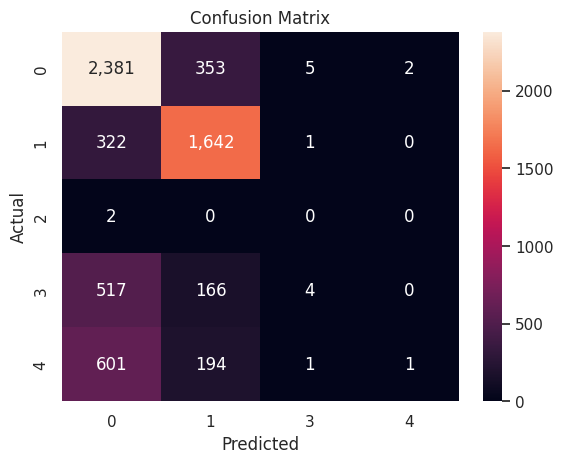

以下解釋皆是模型在測試上的表現

y - ocean_proximity

                 precision    recall      f1-score   support

           0       0.62      0.87      0.73      2741
           1       0.70      0.84      0.76      1965
           2       0.00      0.00      0.00        2
           3       0.36      0.01      0.01       687
           4       0.33      0.00      0.00       797

    accuracy                           0.65      6192

*   測試集的整體表現Accuracy為0.65
*   在預測標籤類別2的表現非常糟糕，其原因是該類別在訓練上的樣本數過少而導致，因此可考慮將該類別刪除


# Learning Curve

In [ ]:
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, n_jobs=-1)
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")

    plt.legend(loc="best")
    plt.show()
plot_learning_curve(lr_model, X_train, y_train)

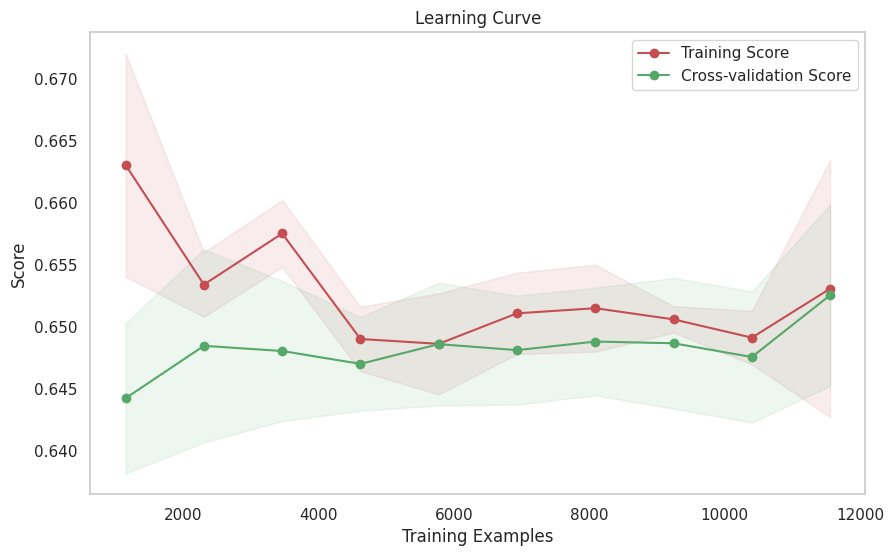